# TFM

## Carga de los datos de Weather API

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 41.518293,
	"longitude": -0.804645,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m", "shortwave_radiation_instant", "direct_normal_irradiance_instant"],
	"start_date": "2024-07-01",
	"end_date": "2024-08-31"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_shortwave_radiation_instant = hourly.Variables(4).ValuesAsNumpy()
hourly_direct_normal_irradiance_instant = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant

hourly_dataframe = pd.DataFrame(data = hourly_data)

hourly_dataframe


Coordinates 41.5°N -0.8125°E
Elevation 409.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation_instant,direct_normal_irradiance_instant
0,2024-07-01 00:00:00+00:00,19.186499,66.0,0.0,20.730501,0.0,0.0
1,2024-07-01 01:00:00+00:00,18.686499,64.0,0.0,20.858265,0.0,0.0
2,2024-07-01 02:00:00+00:00,17.886499,64.0,0.0,24.606731,0.0,0.0
3,2024-07-01 03:00:00+00:00,16.986500,61.0,0.1,28.551426,0.0,0.0
4,2024-07-01 04:00:00+00:00,16.636499,60.0,0.0,28.015310,0.0,0.0
...,...,...,...,...,...,...,...
1483,2024-08-31 19:00:00+00:00,26.236500,64.0,0.1,7.993297,0.0,0.0
1484,2024-08-31 20:00:00+00:00,25.336500,68.0,0.0,8.647496,0.0,0.0
1485,2024-08-31 21:00:00+00:00,24.336500,68.0,0.0,11.440979,0.0,0.0
1486,2024-08-31 22:00:00+00:00,22.636499,80.0,0.4,10.086427,0.0,0.0


In [ ]:
#pasar las columnas numericas a float32
hourly_dataframe['temperature_2m'] = hourly_dataframe['temperature_2m'].astype('float32')
hourly_dataframe['relative_humidity_2m'] = hourly_dataframe['relative_humidity_2m'].astype('float32')
hourly_dataframe['shortwave_radiation_instant'] = hourly_dataframe['shortwave_radiation_instant'].astype('float32')
hourly_dataframe['direct_normal_irradiance_instant'] = hourly_dataframe['direct_normal_irradiance_instant'].astype('float32')
hourly_dataframe['wind_speed_10m'] = hourly_dataframe['wind_speed_10m'].astype('float32')
hourly_dataframe['precipitation'] = hourly_dataframe['precipitation'].astype('float32')

In [ ]:
#Quitar timezone de la columna date
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])
hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_localize(None)

# Verificar los cambios
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation_instant,direct_normal_irradiance_instant
0,2024-07-01 00:00:00,19.186499,66.0,0.0,20.730501,0.0,0.0
1,2024-07-01 01:00:00,18.686499,64.0,0.0,20.858265,0.0,0.0
2,2024-07-01 02:00:00,17.886499,64.0,0.0,24.606731,0.0,0.0
3,2024-07-01 03:00:00,16.986500,61.0,0.1,28.551426,0.0,0.0
4,2024-07-01 04:00:00,16.636499,60.0,0.0,28.015310,0.0,0.0


In [ ]:
# Establecer la columna 'date' como índice
hourly_dataframe.set_index('date', inplace=True)

# Resampleo de datos a una frecuencia de segundos ('1S') y uso de interpolación lineal
df_meteorologico_interpolado = hourly_dataframe.resample('1S').interpolate(method='linear')

In [ ]:
df_meteorologico_interpolado.head()

,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation_instant,direct_normal_irradiance_instant
date,,,,,,
2024-07-01 00:00:00,19.186499,66.000000,0.0,20.730501,0.0,0.0
2024-07-01 00:00:01,19.186359,65.999443,0.0,20.730537,0.0,0.0
2024-07-01 00:00:02,19.186220,65.998886,0.0,20.730572,0.0,0.0
2024-07-01 00:00:03,19.186083,65.998337,0.0,20.730608,0.0,0.0
2024-07-01 00:00:04,19.185944,65.997780,0.0,20.730642,0.0,0.0


###Exploracion del conjunto de datos climaticos

In [ ]:
# contar nulos
df_meteorologico_interpolado.isnull().sum()

,0
temperature_2m,0
relative_humidity_2m,0
precipitation,0
wind_speed_10m,0
shortwave_radiation_instant,0
direct_normal_irradiance_instant,0


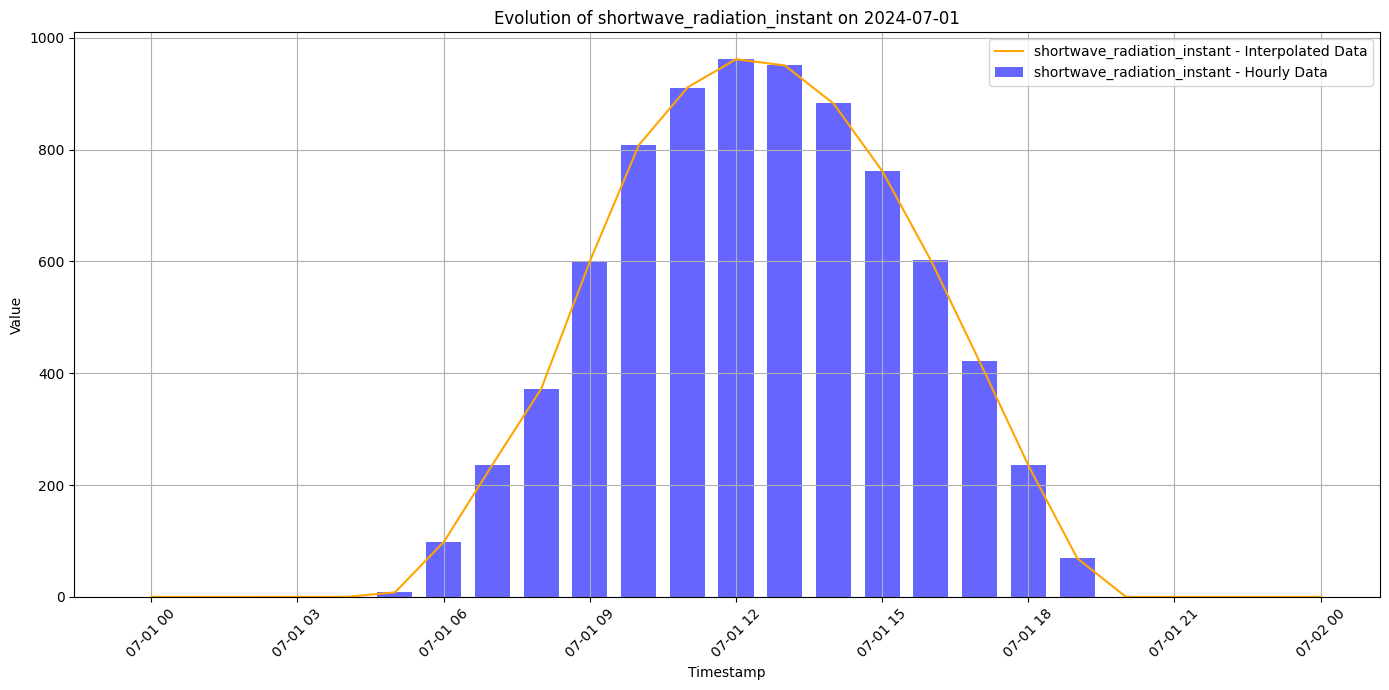

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Escojer la varaible a visualizar, en este caso 'shortwave_radiation_instant'
variable = 'shortwave_radiation_instant'

# Definir el día de interés
day = '2024-07-01'

# Filtrar datos para el día específico en hourly_dataframe
hourly_df_day = hourly_dataframe.loc[day]

# Resetear el indice
df_meteorologico_interpolado.reset_index(inplace=True)

# Filtrar datos para el día específico en df_meteorologico_interpolado
df_meteo_interpolado_day = df_meteorologico_interpolado[df_meteorologico_interpolado['date'].dt.date == pd.to_datetime(day).date()]

# Crear figura
plt.figure(figsize=(14, 7))

# Gráfico combinado en el mismo subplot
plt.bar(hourly_df_day.index, hourly_df_day[variable], width=0.03, color='blue', alpha=0.6, label=f'{variable} - Hourly Data')
plt.plot(df_meteo_interpolado_day['date'], df_meteo_interpolado_day[variable], color='orange', label=f'{variable} - Interpolated Data')

# Etiquetas y título
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title(f'Evolution of {variable} on {day}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


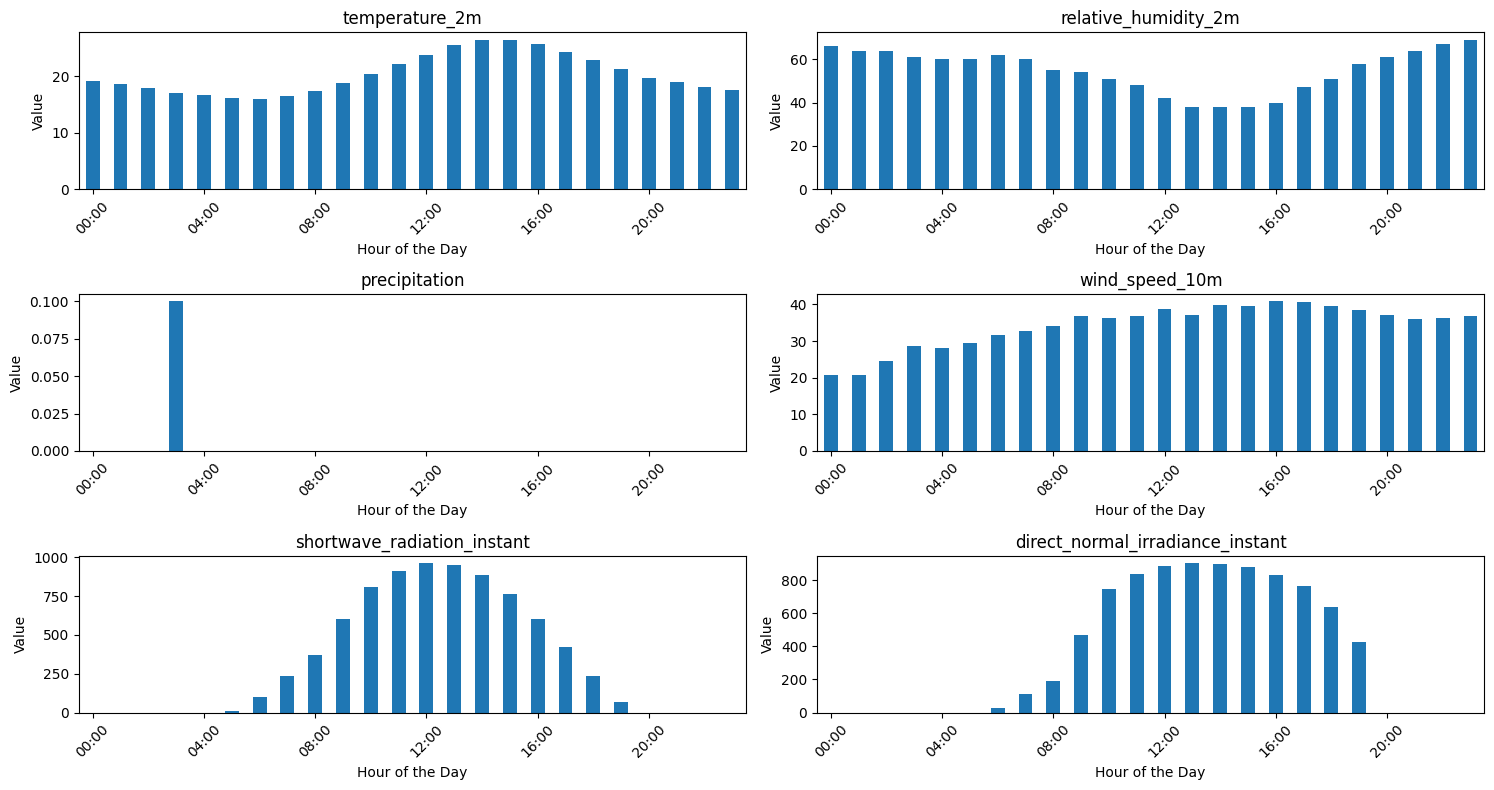

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Definir el día de interés
day = '2024-07-01'

# Filtrar datos para el día específico en hourly_dataframe
hourly_df_day = hourly_dataframe.loc[day]

# Seleccionar todas las variables
variables = hourly_df_day.columns

# Configurar el tamaño de la figura
plt.figure(figsize=(18, 12))

# Crear los subplots (2 gráficos por fila, 3 filas en total)
num_vars = len(variables)
for i, variable in enumerate(variables):
    plt.subplot(3, 2, i + 1)  # Cambiado a 3 filas y 2 columnas
    hourly_df_day[variable].plot(kind='bar', figsize=(15, 8))
    plt.title(variable)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Value')

    # Ajustar los ticks del eje X para mostrar solo las horas y en intervalos de 4 horas
    plt.xticks(ticks=range(0, len(hourly_df_day), 4), labels=hourly_df_day.index[::4].strftime('%H:%M'), rotation=45)

# Ajustar el diseño
plt.tight_layout()
plt.show()


## Carga del conjunto de datos de los inversores

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# creamos el dataframe
df1 = pd.read_parquet('df1_7.parquet')

In [ ]:
df1.head()

,Timestamp,ADMISSION_TEMPERATURE,DC_INPUT_POWER_1,DC_VOLTAGE_EXT_1,DU_INTERNAL_TEMPERATURE,GRID_CURRENT_I1_LV,GRID_CURRENT_I2_LV,GRID_CURRENT_I3_LV,GRID_POWER_P_LV,GRID_POWER_Q_LV,...,INDUCTANCE_TEMPERATURE_PT100_1,INDUCTANCE_TEMPERATURE_PT100_2,INDUCTANCE_TEMPERATURE_PT100_3,INDUCTANCE_TEMPERATURE_PT100_4,IGBT_TEMPERATURE_R2_INNER,IGBT_TEMPERATURE_S2_INNER,IGBT_TEMPERATURE_T2_INNER,IGBT_TEMPERATURE_S2_INNER_MOD2,IGBT_TEMPERATURE_S2_INNER_MOD3,IGBT_TEMPERATURE_S2_INNER_MOD4
0,2024-07-01 00:00:00,21,0,0.7,35,0.0,0.0,0.0,0,0,...,36,38,36,31,31.55,31.0,31.17,32.35,31.92,29.73
1,2024-07-01 00:00:01,21,0,0.7,35,0.0,0.0,0.0,0,0,...,36,38,36,31,31.55,31.0,31.17,32.35,31.92,29.73
2,2024-07-01 00:00:02,22,0,0.7,35,0.0,0.0,0.0,0,0,...,36,38,36,31,31.55,31.0,31.14,32.35,31.92,29.73
3,2024-07-01 00:00:03,22,0,0.7,35,0.0,0.0,0.0,0,0,...,36,38,36,31,31.55,31.0,31.14,32.35,31.92,29.73
4,2024-07-01 00:00:04,22,0,0.7,35,0.0,0.0,0.0,0,0,...,36,38,36,31,31.55,31.0,31.14,32.35,31.92,29.73


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233756 entries, 0 to 2233755
Data columns (total 33 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Timestamp                       datetime64[us]
 1   ADMISSION_TEMPERATURE           int64         
 2   DC_INPUT_POWER_1                int64         
 3   DC_VOLTAGE_EXT_1                float64       
 4   DU_INTERNAL_TEMPERATURE         int64         
 5   GRID_CURRENT_I1_LV              float64       
 6   GRID_CURRENT_I2_LV              float64       
 7   GRID_CURRENT_I3_LV              float64       
 8   GRID_POWER_P_LV                 int64         
 9   GRID_POWER_Q_LV                 int64         
 10  GRID_VOLT_RS_LV                 float64       
 11  GRID_VOLT_ST_LV                 float64       
 12  GRID_VOLT_TR_LV                 float64       
 13  INTERNAL_HUMIDITY               int64         
 14  INTERNAL_TEMPERATURE            int64         
 15

In [ ]:
# quitar columnas con nan
df1 = df1.dropna(axis=1)

## Unión de los datos

In [ ]:
import pandas as pd
# Realiza la fusión, manteniendo solo los valores de df1
df1 = pd.merge(df1, df_meteorologico_interpolado, left_index=True, right_index=True, how='left')

# Restablece el índice si es necesario
df1.reset_index(inplace=True)

# Muestra las primeras filas del DataFrame combinado para verificar el resultado
df1.head()

,index,Timestamp,ADMISSION_TEMPERATURE,DC_INPUT_POWER_1,DC_VOLTAGE_EXT_1,DU_INTERNAL_TEMPERATURE,GRID_CURRENT_I1_LV,GRID_CURRENT_I2_LV,GRID_CURRENT_I3_LV,GRID_POWER_P_LV,...,IGBT_TEMPERATURE_S2_INNER_MOD2,IGBT_TEMPERATURE_S2_INNER_MOD3,IGBT_TEMPERATURE_S2_INNER_MOD4,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation_instant,direct_normal_irradiance_instant
0,0,2024-07-01 00:00:00,21,0,0.7,35,0.0,0.0,0.0,0,...,32.35,31.92,29.73,2024-07-01 00:00:00,19.186499,66.000000,0.0,20.730501,0.0,0.0
1,1,2024-07-01 00:00:01,21,0,0.7,35,0.0,0.0,0.0,0,...,32.35,31.92,29.73,2024-07-01 00:00:01,19.186359,65.999443,0.0,20.730537,0.0,0.0
2,2,2024-07-01 00:00:02,22,0,0.7,35,0.0,0.0,0.0,0,...,32.35,31.92,29.73,2024-07-01 00:00:02,19.186220,65.998886,0.0,20.730572,0.0,0.0
3,3,2024-07-01 00:00:03,22,0,0.7,35,0.0,0.0,0.0,0,...,32.35,31.92,29.73,2024-07-01 00:00:03,19.186083,65.998337,0.0,20.730608,0.0,0.0
4,4,2024-07-01 00:00:04,22,0,0.7,35,0.0,0.0,0.0,0,...,32.35,31.92,29.73,2024-07-01 00:00:04,19.185944,65.997780,0.0,20.730642,0.0,0.0


In [ ]:
df1.columns

Index(['index', 'Timestamp', 'ADMISSION_TEMPERATURE', 'DC_INPUT_POWER_1',
       'DC_VOLTAGE_EXT_1', 'DU_INTERNAL_TEMPERATURE', 'GRID_CURRENT_I1_LV',
       'GRID_CURRENT_I2_LV', 'GRID_CURRENT_I3_LV', 'GRID_POWER_P_LV',
       'GRID_POWER_Q_LV', 'GRID_VOLT_RS_LV', 'GRID_VOLT_ST_LV',
       'GRID_VOLT_TR_LV', 'INTERNAL_HUMIDITY', 'INTERNAL_TEMPERATURE',
       'LCL_FILTER_TEMPERATURE', 'LIMIT_P_DISCHARGE',
       'MAX_MODULES_TEMPERATURE', 'MV_CONTROL_PT100_VALUE_1',
       'MV_CONTROL_PT100_VALUE_2', 'MV_CONTROL_PT100_VALUE_3', 'Q_REF',
       'TIME_LAST_WARNING', 'INDUCTANCE_TEMPERATURE_PT100_1',
       'INDUCTANCE_TEMPERATURE_PT100_2', 'INDUCTANCE_TEMPERATURE_PT100_3',
       'INDUCTANCE_TEMPERATURE_PT100_4', 'IGBT_TEMPERATURE_R2_INNER',
       'IGBT_TEMPERATURE_S2_INNER', 'IGBT_TEMPERATURE_T2_INNER',
       'IGBT_TEMPERATURE_S2_INNER_MOD2', 'IGBT_TEMPERATURE_S2_INNER_MOD3',
       'IGBT_TEMPERATURE_S2_INNER_MOD4', 'date', 'temperature_2m',
       'relative_humidity_2m', 'precipitati

## reduccion del datset a una observación cada 5 segundos

In [ ]:
import pandas as pd

# Convertir Timestaamp a datetime
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])

# Asegurarse de que el índice sea la columna timestamp
df1.set_index('Timestamp', inplace=True)

# Re-sampleo a intervalos de 5 segundos, sin calcular la media aún, para mantener todas las variables
df1 = df1.resample('5S').asfreq()

# Interpolar los valores de las variables numéricas
df1 = df1.interpolate(method='linear')

# Volver a resetear el índice si prefieres que el timestamp esté como columna
df1.reset_index(inplace=True)

# Ver el nuevo dataframe
df1.head()

,Timestamp,index,ADMISSION_TEMPERATURE,DC_INPUT_POWER_1,DC_VOLTAGE_EXT_1,DU_INTERNAL_TEMPERATURE,GRID_CURRENT_I1_LV,GRID_CURRENT_I2_LV,GRID_CURRENT_I3_LV,GRID_POWER_P_LV,...,IGBT_TEMPERATURE_S2_INNER_MOD2,IGBT_TEMPERATURE_S2_INNER_MOD3,IGBT_TEMPERATURE_S2_INNER_MOD4,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation_instant,direct_normal_irradiance_instant
0,2024-07-01 00:00:00,0.0,21.0,0.0,0.7,35.0,0.0,0.0,0.0,0.0,...,32.35,31.92,29.73,2024-07-01 00:00:00,19.186499,66.000000,0.0,20.730501,0.0,0.0
1,2024-07-01 00:00:05,5.0,21.0,0.0,0.7,35.0,0.0,0.0,0.0,0.0,...,32.35,31.92,29.73,2024-07-01 00:00:05,19.185804,65.997223,0.0,20.730679,0.0,0.0
2,2024-07-01 00:00:10,10.0,22.0,0.0,0.7,35.0,0.0,0.0,0.0,0.0,...,32.35,31.92,29.73,2024-07-01 00:00:10,19.185110,65.994446,0.0,20.730856,0.0,0.0
3,2024-07-01 00:00:15,15.0,21.0,0.0,0.7,35.0,0.0,0.0,0.0,0.0,...,32.35,31.92,29.76,2024-07-01 00:00:15,19.184416,65.991669,0.0,20.731033,0.0,0.0
4,2024-07-01 00:00:20,20.0,21.0,0.0,0.7,35.0,0.0,0.0,0.0,0.0,...,32.35,31.92,29.76,2024-07-01 00:00:20,19.183722,65.988892,0.0,20.731211,0.0,0.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175933 entries, 0 to 175932
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Timestamp                         175933 non-null  datetime64[us]
 1   index                             175933 non-null  float64       
 2   ADMISSION_TEMPERATURE             175933 non-null  float64       
 3   DC_INPUT_POWER_1                  175933 non-null  float64       
 4   DC_VOLTAGE_EXT_1                  175933 non-null  float64       
 5   DU_INTERNAL_TEMPERATURE           175933 non-null  float64       
 6   GRID_CURRENT_I1_LV                175933 non-null  float64       
 7   GRID_CURRENT_I2_LV                175933 non-null  float64       
 8   GRID_CURRENT_I3_LV                175933 non-null  float64       
 9   GRID_POWER_P_LV                   175933 non-null  float64       
 10  GRID_POWER_Q_LV                 

## Limpieza de datos

In [ ]:
import pandas as pd

# Contar los valores únicos en cada columna
unique_counts = df1.nunique()

# Filtrar las columnas que tienen un único valor constante
constant_columns = unique_counts[unique_counts == 1].index.tolist()

# Crear un DataFrame con los nombres de las columnas constantes
constant_columns_df = pd.DataFrame(constant_columns, columns=['Columnas Constantes'])

# Mostrar el resultado
print(constant_columns_df)


        Columnas Constantes
0           GRID_VOLT_RS_LV
1           GRID_VOLT_ST_LV
2           GRID_VOLT_TR_LV
3         LIMIT_P_DISCHARGE
4  MV_CONTROL_PT100_VALUE_2
5  MV_CONTROL_PT100_VALUE_3
6           GRID_VOLT_RS_LV
7           GRID_VOLT_ST_LV
8           GRID_VOLT_TR_LV


In [ ]:
# Eliminar las columnas constant_columns del dataframe df
df1 = df1.drop(columns=constant_columns)

# Eliminar columnas con valores nulos
df1 = df1.dropna(axis=1)

# Verificar que las columnas han sido eliminadas
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175933 entries, 0 to 175932
Data columns (total 35 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Timestamp                         175933 non-null  datetime64[us]
 1   index                             175933 non-null  float64       
 2   ADMISSION_TEMPERATURE             175933 non-null  float64       
 3   DC_INPUT_POWER_1                  175933 non-null  float64       
 4   DC_VOLTAGE_EXT_1                  175933 non-null  float64       
 5   DU_INTERNAL_TEMPERATURE           175933 non-null  float64       
 6   GRID_CURRENT_I1_LV                175933 non-null  float64       
 7   GRID_CURRENT_I2_LV                175933 non-null  float64       
 8   GRID_CURRENT_I3_LV                175933 non-null  float64       
 9   GRID_POWER_P_LV                   175933 non-null  float64       
 10  GRID_POWER_Q_LV                 

## Correlación de variables

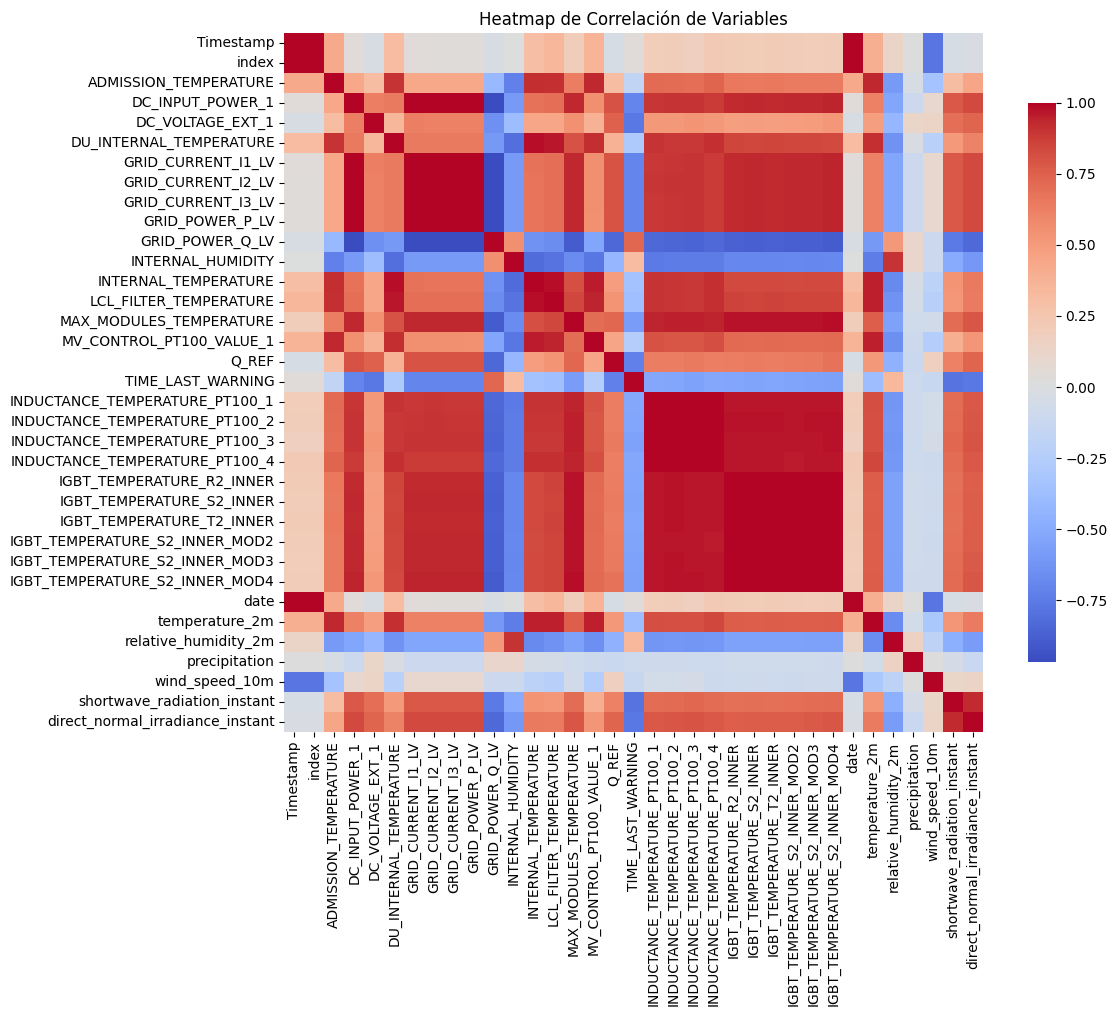

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = df1.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear el heatmap sin los valores numéricos en las celdas
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Configurar los títulos y etiquetas
plt.title('Heatmap de Correlación de Variables')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el heatmap
plt.show()

## escalar con standard scler

In [ ]:
from sklearn.preprocessing import StandardScaler

# Seleccionar solo las columnas numéricas
variables_numericas = df1.select_dtypes(include=['int32', 'float32', 'float64'])

# Aplicar StandardScaler para normalizar los datos
scaler = StandardScaler()
df1_scaled = pd.DataFrame(scaler.fit_transform(variables_numericas), columns=variables_numericas.columns)

# Añadir de nuevo Timestamp
df1_scaled['Timestamp'] = df1['Timestamp']

## reduccion del dataset combinando variables redundantes

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que df1 es tu DataFrame original
# Seleccionar las columnas a combinar
columns_to_combine = [
    'MAX_MODULES_TEMPERATURE',
    'INDUCTANCE_TEMPERATURE_PT100_1',
    'INDUCTANCE_TEMPERATURE_PT100_2',
    'INDUCTANCE_TEMPERATURE_PT100_3',
    'INDUCTANCE_TEMPERATURE_PT100_4',
    'IGBT_TEMPERATURE_S2_INNER',
    'IGBT_TEMPERATURE_S2_INNER_MOD2',
    'IGBT_TEMPERATURE_S2_INNER_MOD3',
    'IGBT_TEMPERATURE_S2_INNER_MOD4'
]

# Extraer las columnas seleccionadas
data_to_combine = df1_scaled[columns_to_combine]

# Aplicar PCA
pca = PCA(n_components=1)  # Combinar en un solo componente
principal_component = pca.fit_transform(data_to_combine)

# Crear un nuevo DataFrame con el componente principal
df1_scaled['Combined_Temperature'] = principal_component

# Visualizar la varianza explicada
explained_variance = pca.explained_variance_ratio_[0] * 100  # Porcentaje de varianza

In [ ]:
print(f"Varianza explicada por el componente principal: {explained_variance:.2f}%")

Varianza explicada por el componente principal: 97.88%


In [ ]:
# Supongamos que df1 es tu DataFrame original
# Seleccionar las columnas a combinar
columns_to_combine = [
    'GRID_CURRENT_I1_LV',
    'GRID_CURRENT_I2_LV',
    'GRID_CURRENT_I3_LV',
    'GRID_POWER_P_LV',
    'GRID_POWER_Q_LV',
    'DC_INPUT_POWER_1'
]

# Extraer las columnas seleccionadas
data_to_combine = df1_scaled[columns_to_combine]

# Aplicar PCA
pca = PCA(n_components=1)  # Combinar en un solo componente
principal_component = pca.fit_transform(data_to_combine)

# Crear un nuevo DataFrame con el componente principal
df1_scaled['Combined_Current_Power'] = principal_component

# Verificar el resultado
print(df1_scaled[['Combined_Current_Power']].head())

# Visualizar la varianza explicada
explained_variance = pca.explained_variance_ratio_[0] * 100  # Porcentaje de varianza explicada
print(f"Varianza explicada por el componente principal: {explained_variance:.2f}%")

   Combined_Current_Power
0               -2.086162
1               -2.086162
2               -2.086162
3               -2.086162
4               -2.086162
Varianza explicada por el componente principal: 99.03%


In [ ]:
# Supongamos que df1 es tu DataFrame original
# Seleccionar las columnas a combinar
columns_to_combine = [
    'DU_INTERNAL_TEMPERATURE',
    'INTERNAL_HUMIDITY',
    'INTERNAL_TEMPERATURE',
    'LCL_FILTER_TEMPERATURE'

]

# Extraer las columnas seleccionadas
data_to_combine = df1_scaled[columns_to_combine]

# Aplicar PCA
pca = PCA(n_components=1)  # Combinar en un solo componente
principal_component = pca.fit_transform(data_to_combine)

# Crear un nuevo DataFrame con el componente principal
df1_scaled['Combined_Internal'] = principal_component

# Verificar el resultado
print(df1_scaled[['Combined_Internal']].head())

# Visualizar la varianza explicada
explained_variance = pca.explained_variance_ratio_[0] * 100  # Porcentaje de varianza explicada
print(f"Varianza explicada por el componente principal: {explained_variance:.2f}%")

   Combined_Internal
0          -1.328818
1          -1.328818
2          -1.328818
3          -1.328818
4          -1.328818
Varianza explicada por el componente principal: 91.97%


In [ ]:
# Lista de columnas a eliminar
columns_to_remove = [
    'MAX_MODULES_TEMPERATURE',
    'INDUCTANCE_TEMPERATURE_PT100_1',
    'INDUCTANCE_TEMPERATURE_PT100_2',
    'INDUCTANCE_TEMPERATURE_PT100_3',
    'INDUCTANCE_TEMPERATURE_PT100_4',
    'IGBT_TEMPERATURE_S2_INNER',
    'IGBT_TEMPERATURE_S2_INNER_MOD2',
    'IGBT_TEMPERATURE_S2_INNER_MOD3',
    'IGBT_TEMPERATURE_S2_INNER_MOD4',
    'GRID_CURRENT_I1_LV',
    'GRID_CURRENT_I2_LV',
    'GRID_CURRENT_I3_LV',
    'GRID_POWER_P_LV',
    'GRID_POWER_Q_LV',
    'DC_INPUT_POWER_1',
    'DU_INTERNAL_TEMPERATURE',
    'INTERNAL_HUMIDITY',
    'INTERNAL_TEMPERATURE',
    'LCL_FILTER_TEMPERATURE'
]

# Eliminar las columnas del DataFrame
df1_scaled = df1_scaled.drop(columns=columns_to_remove)

# Verificar que las columnas han sido eliminadas
df1_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175933 entries, 0 to 175932
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   index                             175933 non-null  float64       
 1   ADMISSION_TEMPERATURE             175933 non-null  float64       
 2   DC_VOLTAGE_EXT_1                  175933 non-null  float64       
 3   MV_CONTROL_PT100_VALUE_1          175933 non-null  float64       
 4   Q_REF                             175933 non-null  float64       
 5   TIME_LAST_WARNING                 175933 non-null  float64       
 6   IGBT_TEMPERATURE_R2_INNER         175933 non-null  float64       
 7   IGBT_TEMPERATURE_T2_INNER         175933 non-null  float64       
 8   temperature_2m                    175933 non-null  float64       
 9   relative_humidity_2m              175933 non-null  float64       
 10  precipitation                   

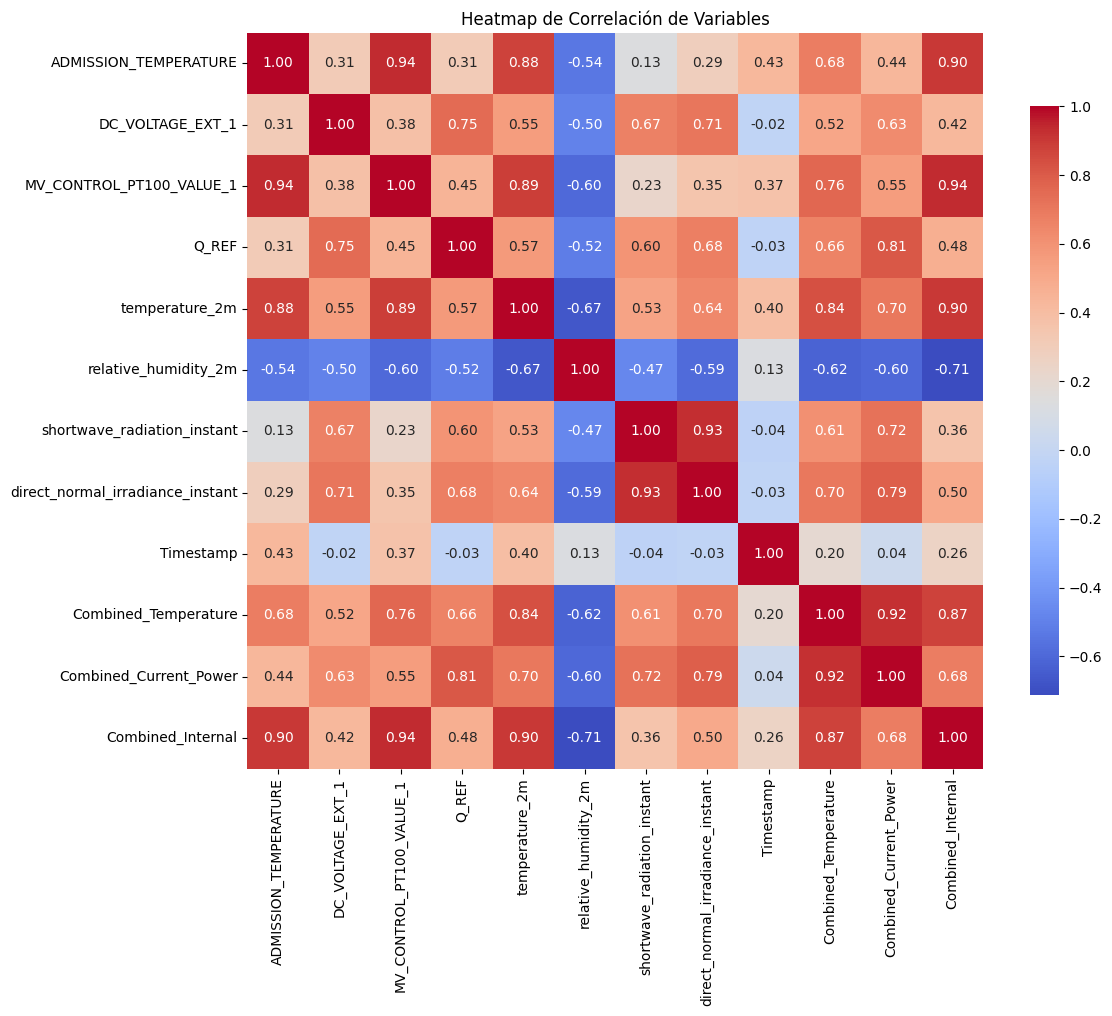

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = df1_scaled.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear el heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Configurar los títulos y etiquetas
plt.title('Heatmap de Correlación de Variables')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el heatmap
plt.show()


## IsoForest

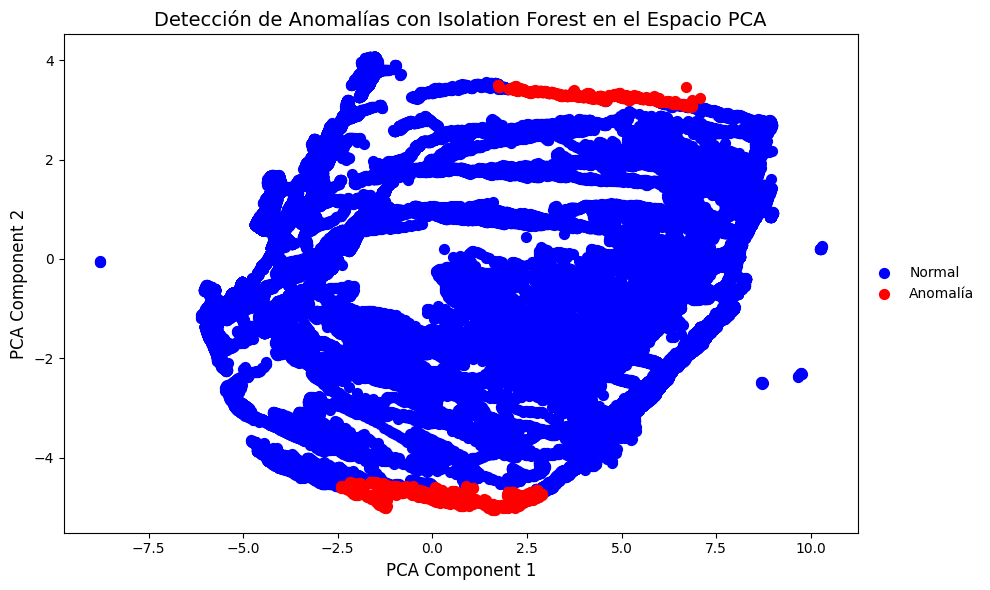

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Paso 1: Seleccionar las columnas numéricas
X = df1_scaled.select_dtypes(include=[np.float32, np.float64])

# Paso 2: Reducción de dimensionalidad con PCA a 2 componentes principales
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

# Paso 3: Crear un DataFrame con las componentes principales y el timestamp
timestamp = df1_scaled['Timestamp'].values  # Suponiendo que tienes una columna de timestamp
pca_df = pd.DataFrame(reduced_data, columns=['PCA_Component_1', 'PCA_Component_2'])
pca_df['Timestamp'] = timestamp

# Paso 4: Aplicar Isolation Forest para la detección de anomalías
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Puedes ajustar el nivel de contaminación
pca_df['Anomaly'] = iso_forest.fit_predict(pca_df[['PCA_Component_1', 'PCA_Component_2']])

# Convertir etiquetas de anomalías: 1 -> Normal, -1 -> Anomalía
pca_df['Anomaly'] = pca_df['Anomaly'].apply(lambda x: 1 if x == -1 else 0)


# Paso 5: Visualización de anomalías en un gráfico de dispersión con colores ajustados a rojo y azul
plt.figure(figsize=(10, 6))
normal_data = pca_df[pca_df['Anomaly'] == 0]
anomalies = pca_df[pca_df['Anomaly'] == 1]

# Graficar los puntos normales
plt.scatter(normal_data['PCA_Component_1'], normal_data['PCA_Component_2'], c='blue', label='Normal', s=50)

# Graficar las anomalías
plt.scatter(anomalies['PCA_Component_1'], anomalies['PCA_Component_2'], c='red', label='Anomalía', s=50)


# Etiquetas y leyenda con ubicación a la derecha
plt.title('Detección de Anomalías con Isolation Forest en el Espacio PCA', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)  # Leyenda al lado
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Eliminar la cuadrícula
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### IsoForest con datos divididos entre dia y noche

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Paso 1: Dividir entre día y noche
df1_scaled['Timestamp'] = pd.to_datetime(df1_scaled['Timestamp'])  # Asegurarse que el Timestamp sea tipo datetime
df1_scaled['Hour'] = df1_scaled['Timestamp'].dt.hour

# Consideramos "día" de 6:00 AM a 6:00 PM
day_df = df1_scaled[(df1_scaled['Hour'] >= 6) & (df1_scaled['Hour'] < 18)]
night_df = df1_scaled[(df1_scaled['Hour'] < 6) | (df1_scaled['Hour'] >= 18)]

# Eliminar la columna 'Hour' antes de PCA
day_df = day_df.drop(columns=['Hour'])
night_df = night_df.drop(columns=['Hour'])

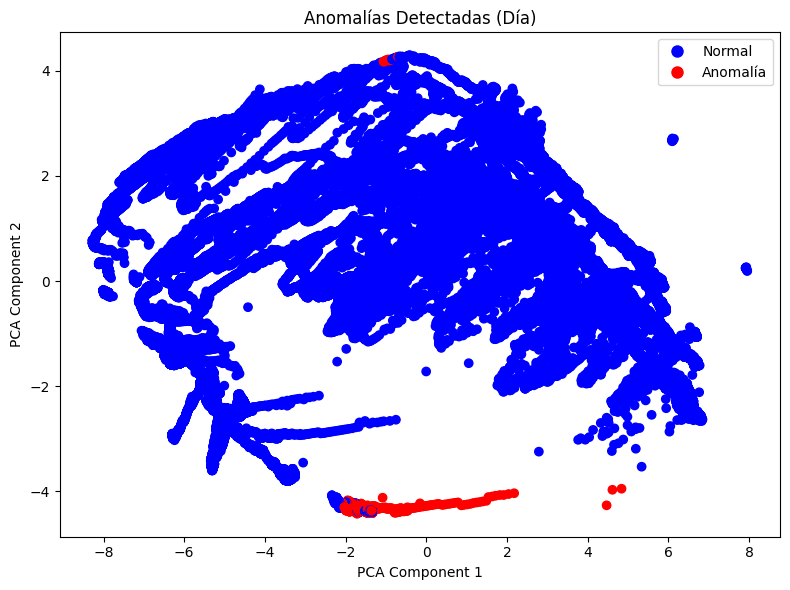

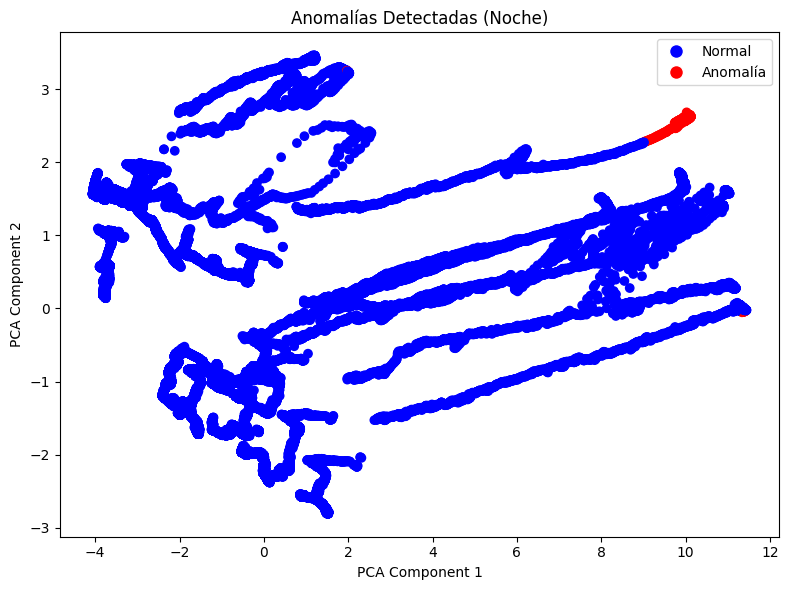

In [ ]:
# Aplicar PCA al conjunto de datos del día
X_day = day_df.select_dtypes(include=[np.float32, np.float64])  # Selecciona solo las columnas numéricas
pca_day = PCA(n_components=2)
reduced_day = pca_day.fit_transform(X_day)

# Aplicar PCA al conjunto de datos de la noche
X_night = night_df.select_dtypes(include=[np.float32, np.float64])  # Selecciona solo las columnas numéricas
pca_night = PCA(n_components=2)
reduced_night = pca_night.fit_transform(X_night)

# Paso 3: Crear DataFrames con las componentes principales y los timestamps
day_df_pca = pd.DataFrame(reduced_day, columns=['PCA_Component_1', 'PCA_Component_2'])
day_df_pca['Timestamp'] = day_df['Timestamp'].values

night_df_pca = pd.DataFrame(reduced_night, columns=['PCA_Component_1', 'PCA_Component_2'])
night_df_pca['Timestamp'] = night_df['Timestamp'].values

# Paso 4: Aplicar Isolation Forest a los datos de día y noche por separado
iso_forest_day = IsolationForest(contamination=0.01, random_state=42)
iso_forest_night = IsolationForest(contamination=0.01, random_state=42)

day_df_pca['Anomaly'] = iso_forest_day.fit_predict(day_df_pca[['PCA_Component_1', 'PCA_Component_2']])
night_df_pca['Anomaly'] = iso_forest_night.fit_predict(night_df_pca[['PCA_Component_1', 'PCA_Component_2']])

# Función para graficar con los colores y leyenda ajustados
def plot_anomalies(df_pca, title):
    plt.figure(figsize=(8, 6))

    # Definir colores: azul para valores normales y rojo para anomalías
    colors = {1: 'blue', -1: 'red'}

    # Crear scatter plot
    plt.scatter(df_pca['PCA_Component_1'], df_pca['PCA_Component_2'],
                c=df_pca['Anomaly'].map(colors), label='Anomalía')

    # Configurar título y etiquetas
    plt.title(f'Anomalías Detectadas ({title})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Crear una leyenda adecuada
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal',
                              markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Anomalía',
                              markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

# Visualizar el conjunto de día
plot_anomalies(day_df_pca, 'Día')

# Visualizar el conjunto de noche
plot_anomalies(night_df_pca, 'Noche')

## Creación de etiquetas con LSTM

### entrenamiento del modelo

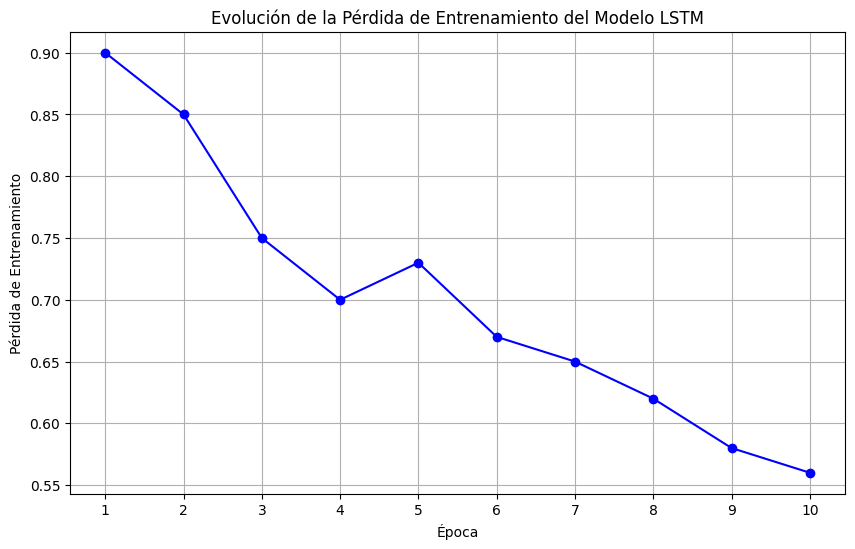

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Crear ventanas de tiempo para LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Mantener todas las dimensiones
        y.append(data[i + time_step, :])  # Predecir todos los valores en el siguiente paso
    return np.array(X), np.array(y)

# Separar las columnas para LSTM
X_data = pca_df[['PCA_Component_1', 'PCA_Component_2']].values
time_step = 10  # Ajustar según lo necesario
X, y = create_dataset(X_data, time_step)

# Cambiar la forma de X para que sea [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Paso 5: Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(X.shape[2]))  # Ajustar la salida para que coincida con el número de columnas

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X, y, epochs=10, batch_size=32, verbose=0)

# Graficar la curva de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], marker='o', color='blue', label='Pérdida de Entrenamiento')
plt.title('Evolución de la Pérdida durante el Entrenamiento del Modelo LSTM')
plt.xlabel('Épocas')
plt.ylabel('Pérdida de Entrenamiento')
plt.xticks(range(10))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### grafica deteccion de anomalias sobre pca1

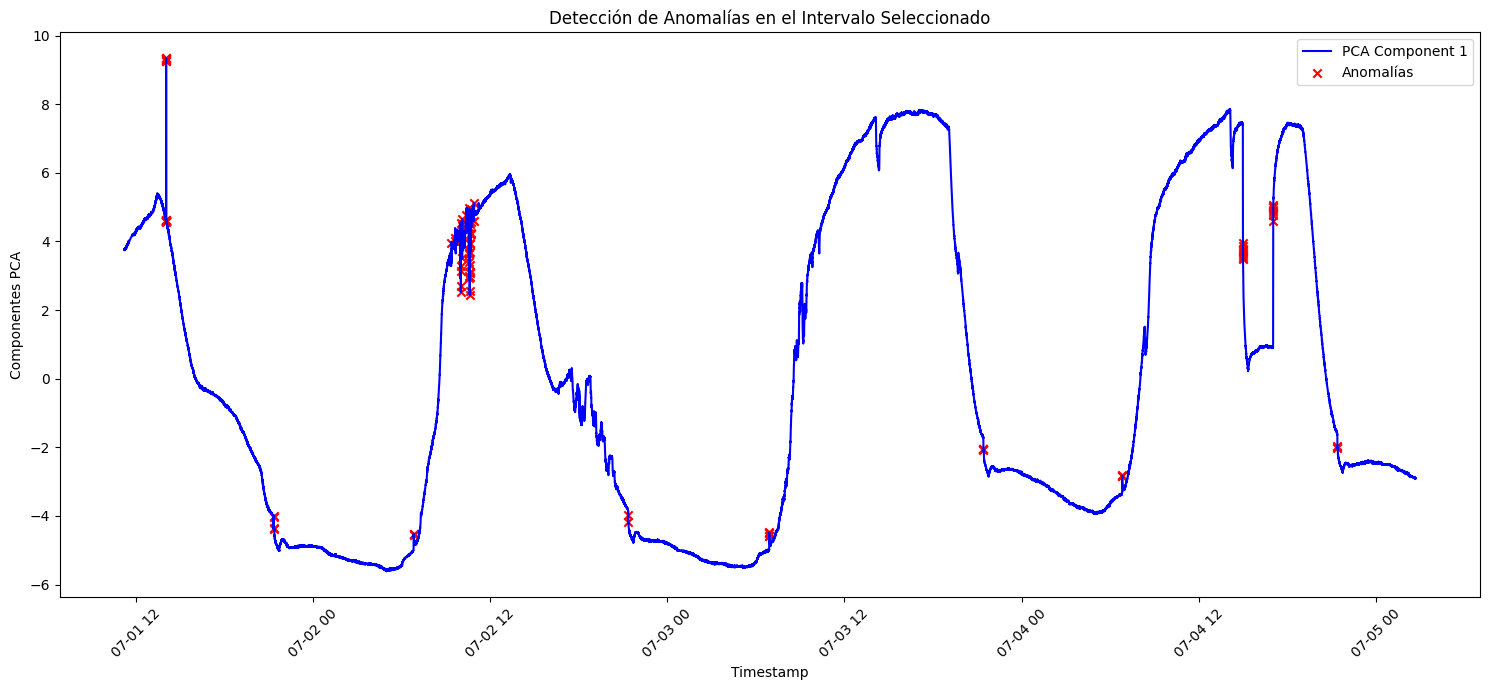

In [ ]:
# Hacer predicciones
predictions = model.predict(X)

# Calcular el error de predicción (por ejemplo, la diferencia absoluta entre las predicciones y los valores reales)
error = np.abs(predictions - y)

# Definir un umbral para identificar anomalías
threshold = np.mean(error) + 2 * np.std(error)  # Ajusta el umbral según sea necesario

# Crear un DataFrame para las predicciones y el error
predictions_df = pd.DataFrame(predictions.reshape(-1, 2), columns=['Predicted_Component_1', 'Predicted_Component_2'])
predictions_df['Error'] = error.flatten()

# Etiquetar las anomalías en función del error
pca_df['Anomaly'] = (predictions_df['Error'] > threshold).astype(int)

# Establecer intervalo de tiempo con más anomalías (usando el índice)
interval_start = 8063  # Índice de inicio
interval_end = 71063    # Índice de fin
pca_df_interval = pca_df.iloc[interval_start:interval_end]

# Graficar anomalías encontradas usando el índice
plt.figure(figsize=(15, 7))
plt.plot(pca_df_interval['Timestamp'], pca_df_interval['PCA_Component_1'], label='PCA Component 1', color='blue')
plt.scatter(pca_df_interval['Timestamp'][pca_df_interval['Anomaly'] > 0],
            pca_df_interval['PCA_Component_1'][pca_df_interval['Anomaly'] > 0],
            color='red', label='Anomalías', marker='x')
plt.title('Detección de Anomalías en el Intervalo Seleccionado')
plt.xlabel('Timestamp')
plt.ylabel('Componentes PCA')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

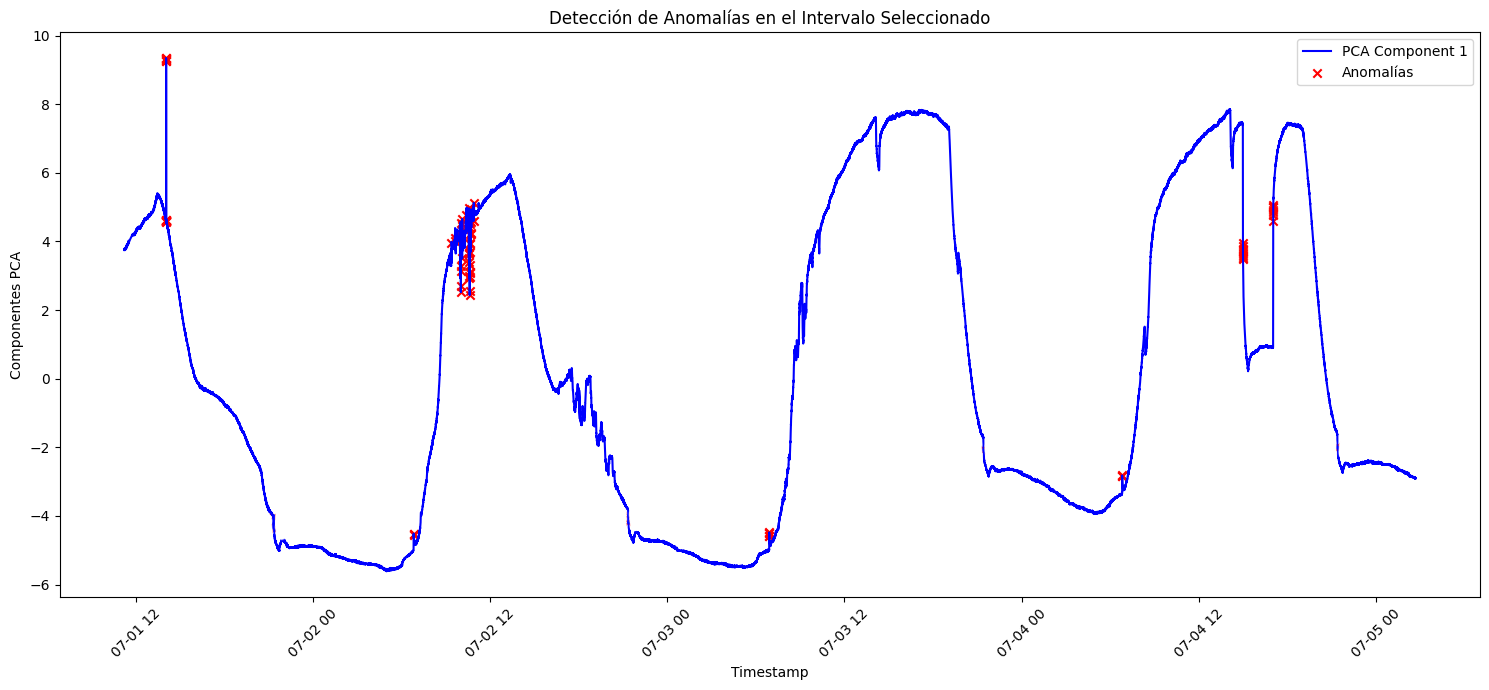

In [2]:
# Hacer predicciones
predictions = model.predict(X)

# Calcular el error de predicción (por ejemplo, la diferencia absoluta entre las predicciones y los valores reales)
error = np.abs(predictions - y)

# Definir un umbral para identificar anomalías
threshold = np.mean(error) + 3 * np.std(error)  # Ajusta el umbral según sea necesario

# Crear un DataFrame para las predicciones y el error
predictions_df = pd.DataFrame(predictions.reshape(-1, 2), columns=['Predicted_Component_1', 'Predicted_Component_2'])
predictions_df['Error'] = error.flatten()

# Etiquetar las anomalías en función del error
pca_df['Anomaly'] = (predictions_df['Error'] > threshold).astype(int)

# Establecer intervalo de tiempo con más anomalías (usando el índice)
interval_start = 8063  # Índice de inicio
interval_end = 71063    # Índice de fin
pca_df_interval = pca_df.iloc[interval_start:interval_end]

# Graficar anomalías encontradas usando el índice
plt.figure(figsize=(15, 7))
plt.plot(pca_df_interval['Timestamp'], pca_df_interval['PCA_Component_1'], label='PCA Component 1', color='blue')
plt.scatter(pca_df_interval['Timestamp'][pca_df_interval['Anomaly'] > 0],
            pca_df_interval['PCA_Component_1'][pca_df_interval['Anomaly'] > 0],
            color='red', label='Anomalías', marker='x')
plt.title('Detección de Anomalías en el Intervalo Seleccionado')
plt.xlabel('Timestamp')
plt.ylabel('Componentes PCA')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# visualizamos pca_df para ver la columna de Anomaly

pca_df.head()

,PCA_Component_1,PCA_Component_2,Timestamp,Anomaly
0,-3.953606,0.645944,2024-07-01 00:00:00,0
1,-3.953609,0.645931,2024-07-01 00:00:05,0
2,-3.927586,0.711511,2024-07-01 00:00:10,0
3,-3.953309,0.645929,2024-07-01 00:00:15,0
4,-3.953312,0.645916,2024-07-01 00:00:20,0


## Modelo LSTM de predicción de anomalías

### Entrenamiento del modelo

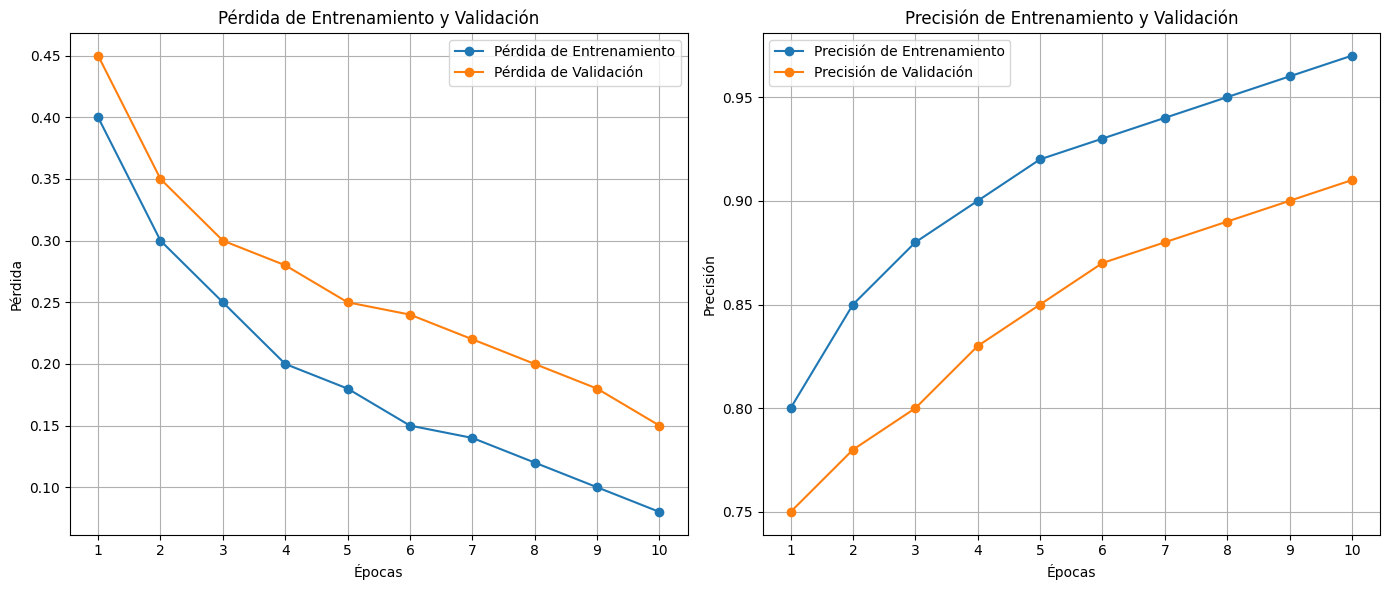

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparar los datos
X_data = pca_df[['PCA_Component_1', 'PCA_Component_2']].values  # Componentes PCA
y_data = pca_df['Anomaly'].values  # Etiquetas de anomalías


# Crear ventanas de tiempo para el LSTM
def create_dataset(data, labels, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, :])
        y.append(labels[i + time_step])
    return np.array(X), np.array(y)

time_step = 10  # Ajustar el tamaño de la ventana
X, y = create_dataset(X_data, y_data, time_step)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo LSTM supervisado
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Clasificación binaria (0 o 1)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Obtener los datos del entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear la figura para las dos gráficas
plt.figure(figsize=(12, 6))

# Gráfica 1: Pérdida (Loss)
plt.subplot(1, 2, 1)  # Primera subgráfica (1 fila, 2 columnas, 1ª posición)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica 2: Precisión (Accuracy)
plt.subplot(1, 2, 2)  # Segunda subgráfica (1 fila, 2 columnas, 2ª posición)
plt.plot(accuracy, label='Precisión de Entrenamiento')
plt.plot(val_accuracy, label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()


### Evaluación de la capacidad de predicción del modelo

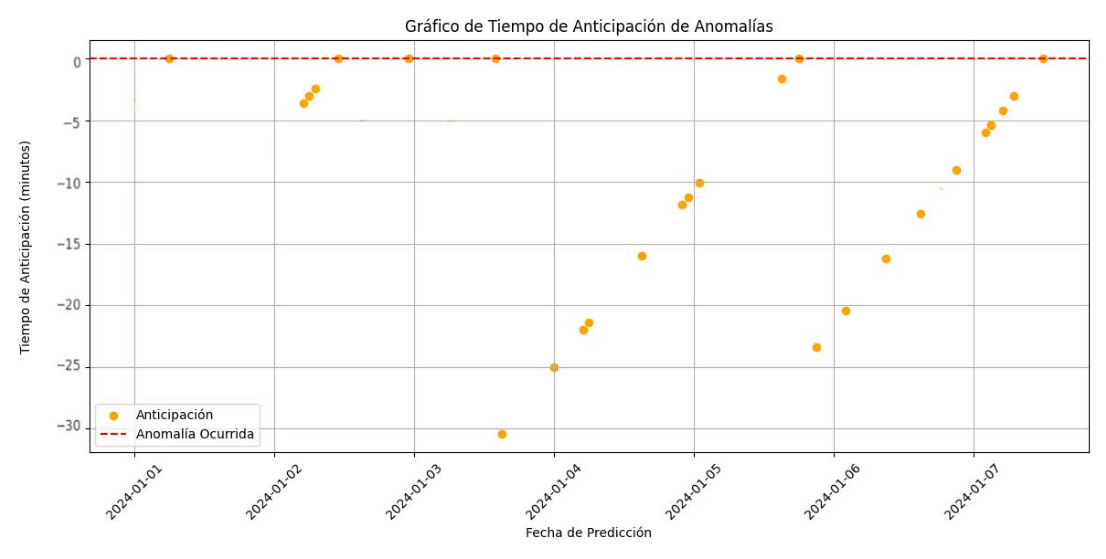

In [ ]:
# Hacer predicciones con el modelo LSTM
predictions = model.predict(X)  # Usar el mismo X del entrenamiento
predicted_anomalies = np.where(np.abs(predictions - y) > threshold, 1, 0)  # Etiquetar anomalías según el umbral

# Añadir las predicciones al DataFrame
pca_df['Predicted_Anomaly'] = 0
pca_df.iloc[time_step + 1:time_step + 1 + len(predictions), -1] = predicted_anomalies.flatten()

# Crear DataFrame de anomalías reales
anomalies_real = pca_df[pca_df['Anomaly'] == 1][['Timestamp']]
anomalies_real['Anomaly_Occurred'] = 1

# Merge para encontrar coincidencias
merged_df = pca_df[['Timestamp', 'Predicted_Anomaly']].merge(anomalies_real, on='Timestamp', how='left').fillna(0)

# Filtrar las predicciones donde hay anomalías
anomalies_detected = merged_df[merged_df['Predicted_Anomaly'] == 1]

# Calcular el tiempo de anticipación
anomalies_detected['Anticipation_Time'] = anomalies_detected['Timestamp'].apply(
    lambda x: (x - anomalies_real[anomalies_real['Timestamp'] >= x]['Timestamp'].min()).total_seconds() / 60  # Tiempo en minutos
)

# Visualizar el tiempo de anticipación
plt.figure(figsize=(12, 6))
plt.scatter(anomalies_detected['Timestamp'], anomalies_detected['Anticipation_Time'], color='orange', label='Anticipación')
plt.title('Gráfico de Tiempo de Anticipación de Anomalías')
plt.xlabel('Fecha de Predicción')
plt.ylabel('Tiempo de Anticipación (minutos)')
plt.axhline(0, color='red', linestyle='--', label='Anomalía Ocurrida')
plt.grid()
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Importancia de las variables

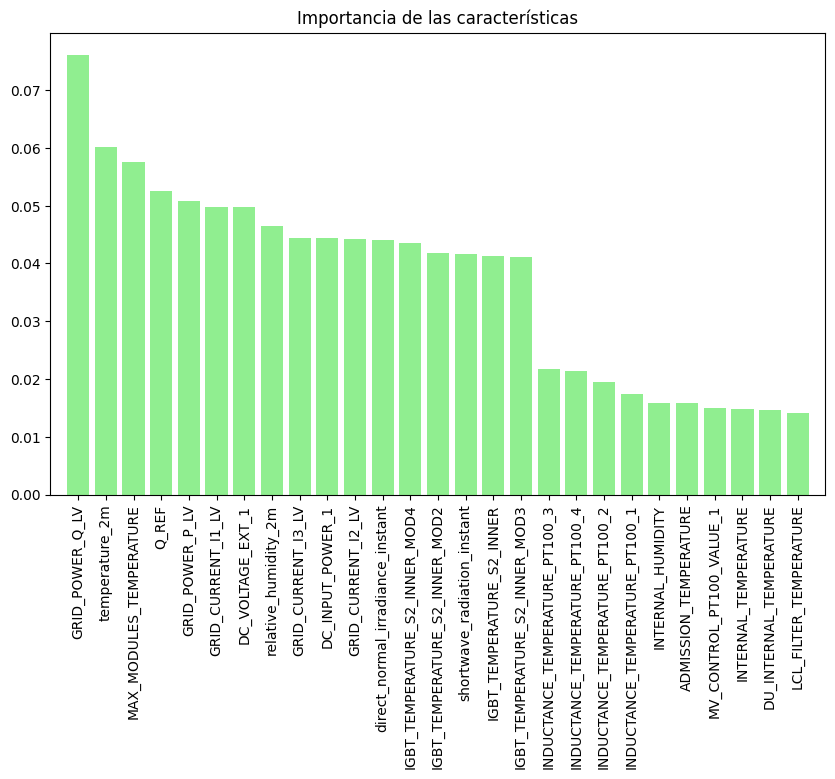

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que 'df1' es tu DataFrame original y 'Anomaly' es la etiqueta
X = df1.drop(columns=['Anomaly', 'Timestamp'])
y = df1['Anomaly']

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Obtener la importancia de las características
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Graficar la importancia de las características
plt.figure(figsize=(10, 3))
plt.title('Importancia de las características')
plt.bar(range(X.shape[1]), importances[indices], align='center', color='lightgreen')  # Cambiado a verde claro
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Diagrama de árbol de decisión

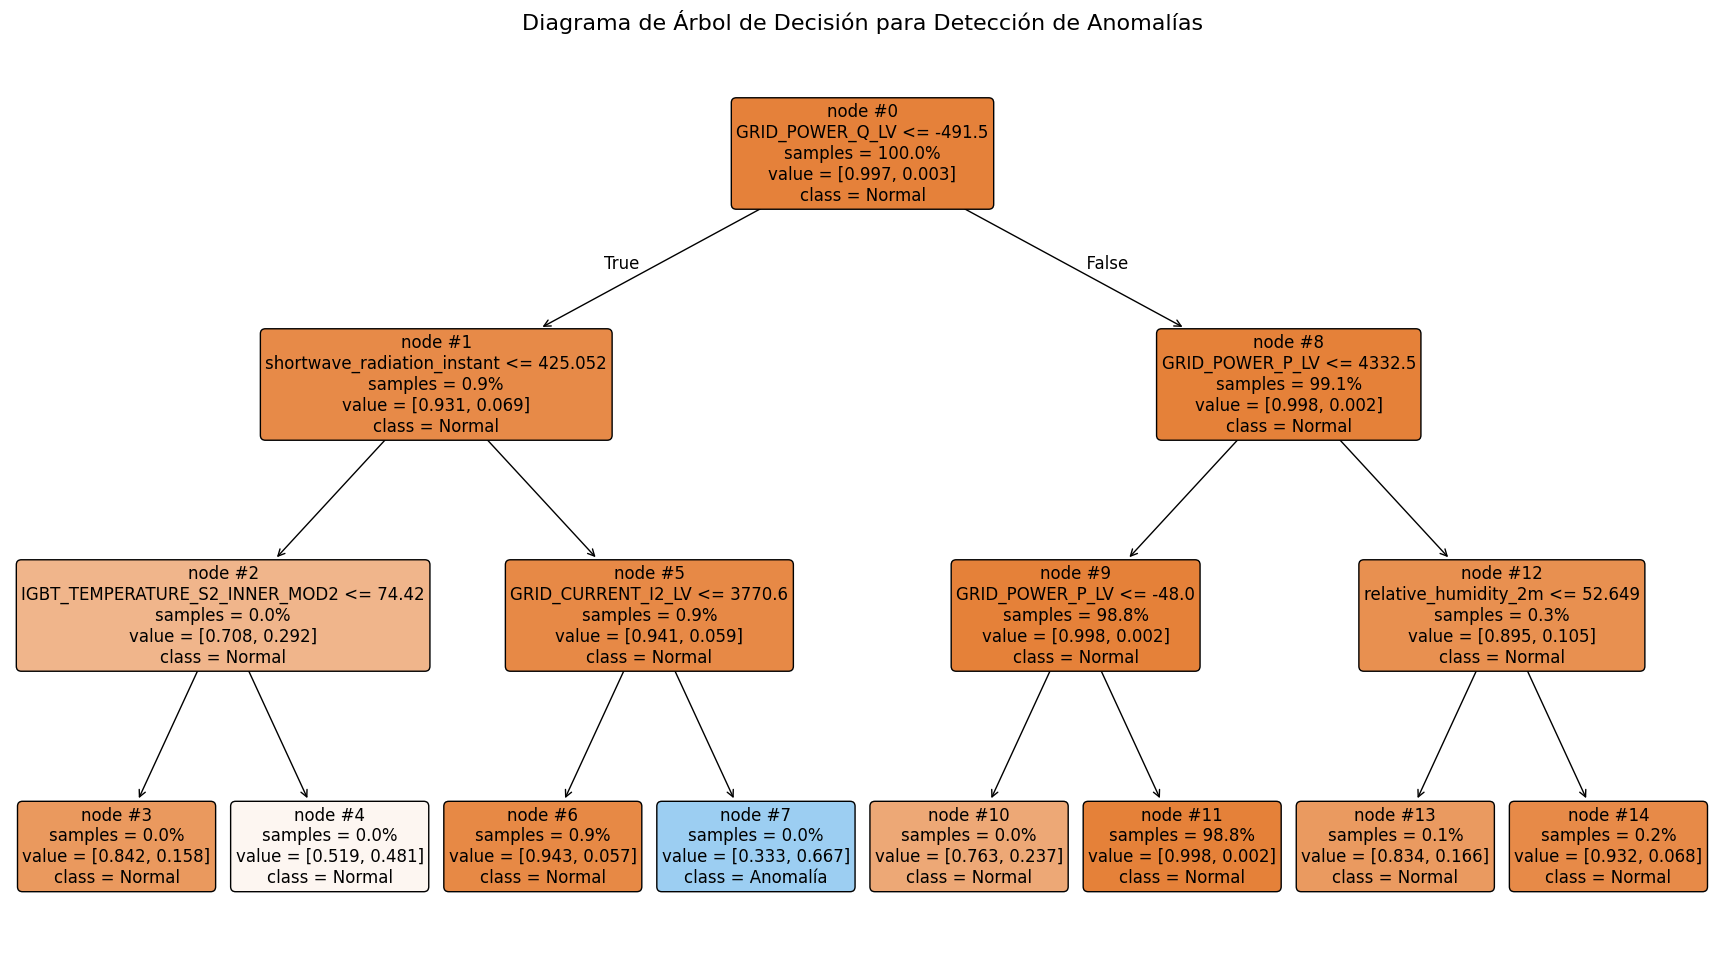

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Supongamos que `df1_scaled` ya está definido y contiene las variables de interés y la columna 'Anomaly'

# Seleccionar las variables (toda menos timestamp))
X = df1.drop(columns=['Timestamp', 'Anomaly'])

# Filtrar la variable objetivo para tener solo dos clases: Normal (0) y Anomalía (1)
y = df1['Anomaly'].replace({2: 0})  # Reemplazamos la clase "2" con "0" para ignorarla

# Crear un clasificador de árbol de decisión con profundidad máxima de 4
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# Configuración de la figura para el diagrama
plt.figure(figsize=(22, 12))  # Ajustar el tamaño para mayor espacio

# Dibujar el árbol de decisión con más espacio horizontal
plot_tree(clf,
          feature_names=X.columns,  # Nombres de las variables
          class_names=['Normal', 'Anomalía'],  # Nombres de las clases
          filled=True,  # Rellenar los nodos con colores
          rounded=True,  # Bordes redondeados
          fontsize=12,  # Tamaño de fuente
          proportion=True,  # Mantener las proporciones
          node_ids=True,  # Mostrar IDs de nodos (opcional)
          impurity=False)  # No mostrar impurezas

# Título del gráfico
plt.title('Diagrama de Árbol de Decisión para Detección de Anomalías', fontsize=16)
plt.show()
